<a href="https://colab.research.google.com/github/KTAP8/SpeechRecognitionUBCproject/blob/main/Krittapas_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipywebrtc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 7.5 MB/s eta 0:00:00


In [ ]:
import torchaudio
from IPython.display import Audio
import IPython

from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
!pip install audio-extract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 28.8 MB/s eta 0:00:00
  Attempting uninstall: imageio-ffmpeg
    Found existing installation: imageio-ffmpeg 0.5.1
    Uninstalling imageio-ffmpeg-0.5.1:
      Successfully uninstalled imageio-ffmpeg-0.5.1


In [ ]:
!pip install pydub

In [ ]:
from audio_extract import extract_audio

extract_audio(input_path="./video_final_touch.mov",
              output_path="./audio.mp3",
              )

Success : audio file has been saved to "/content/audio.mp3".


In [ ]:
sig, sr = torchaudio.load("audio.mp3")

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

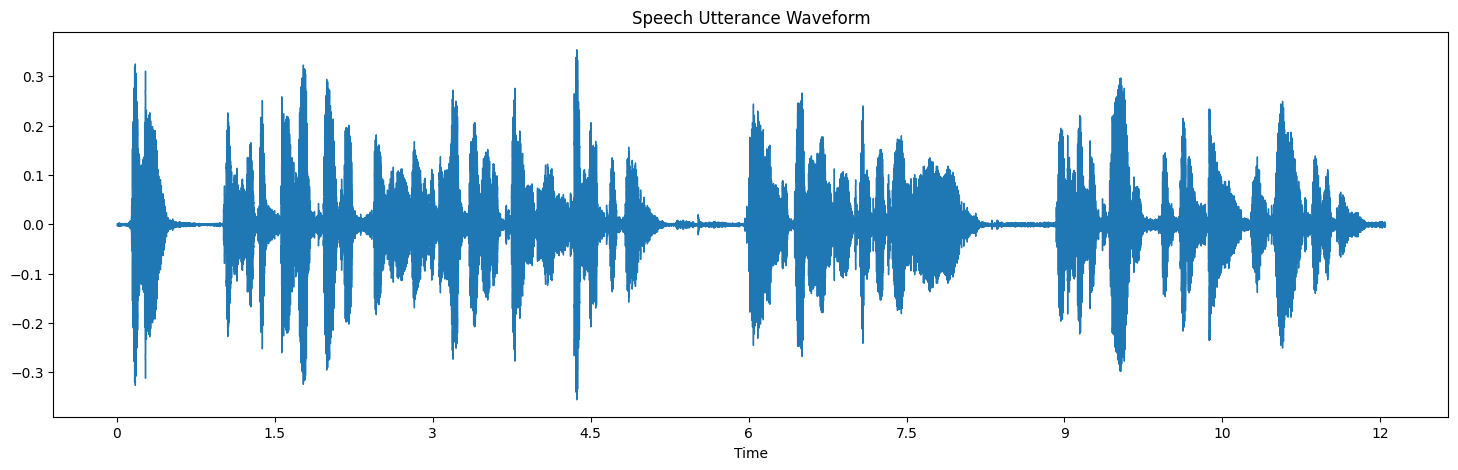

In [ ]:
plt.figure(figsize=(18, 5))
librosa.display.waveshow(sig.numpy(), sr=sr)
plt.title("Speech Utterance Waveform")
plt.show()

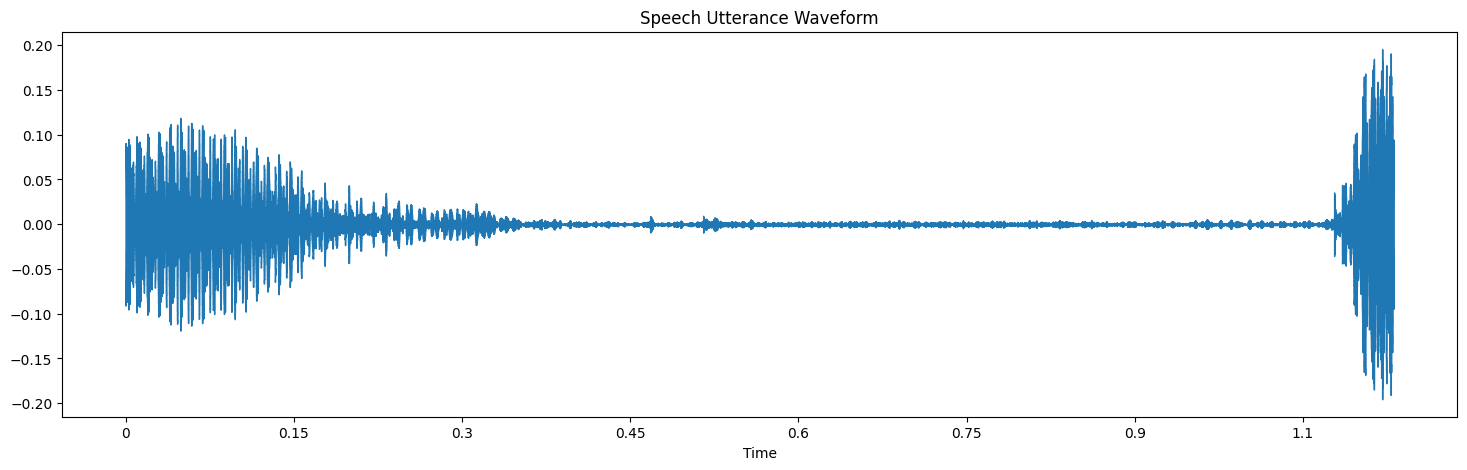

In [ ]:
plt.figure(figsize=(18, 5))
librosa.display.waveshow(sig.numpy()[:,345744:395621], sr=sr)
plt.title("Speech Utterance Waveform")
plt.show()

In [ ]:
print(sig.shape)
print(sr)

sec = sig.shape[1] / sr
print(sec)

silence_length = 0.5*sr
print(silence_length)

torch.Size([1, 531197])
44100
12.045283446712018
22050.0


In [ ]:
from pydub import AudioSegment, silence

myaudio = AudioSegment.from_mp3("audio.mp3")
silences = silence.detect_silence(myaudio, min_silence_len = 1000, silence_thresh=-34)
silences = [((start/1000),(stop/1000)) for start,stop in silences] #convert to sec

indexes = []
for start, stop in silences:
  indexes.append(int(start*sr))
  indexes.append(int(stop*sr))

indexes.insert(0,0)
indexes.append(sig.shape[1])
print(indexes)

[0, 214193, 267290, 345744, 395621, 531197]


In [ ]:
def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)

index = list(pairwise(indexes))
print(index)

[(0, 214193), (267290, 345744), (395621, 531197)]


In [ ]:
sigs = []
for start, stop in index:
  sigs.append(sig[:,start:stop])



In [ ]:
silences_np = np.array(silences)
x_axis = silences_np*sr
print(x_axis)

[[214193.7 267290.1]
 [345744.  395621.1]]


In [ ]:
import torch
import torchaudio
from torchaudio.utils import download_asset
import IPython
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

#create pipeline
bundle = torchaudio.pipelines.WAV2VEC2_ASR_LARGE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

2.3.0+cu121
2.3.0+cu121
cuda
Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
model_asr = bundle.get_model().to(device)

print(model_asr.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_large_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_large_ls960_asr_ls960.pth
100%|██████████| 1.18G/1.18G [00:07<00:00, 176MB/s]


<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [ ]:
sig.to(device)

tensor([[-0.0008, -0.0010, -0.0010,  ..., -0.0006, -0.0008, -0.0007]])

In [ ]:
sig = sig.to(device)
if sr != bundle.sample_rate:
    waveform = torchaudio.functional.resample(sig, sr, bundle.sample_rate)

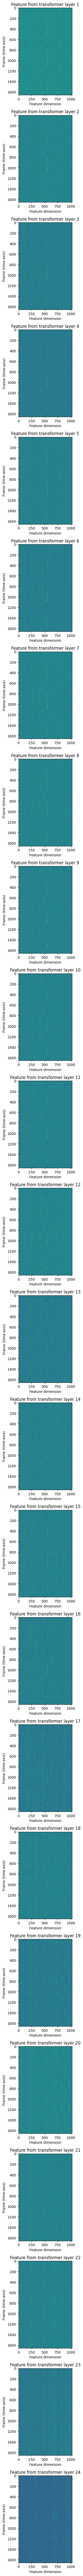

In [ ]:
#test on transcripting before translating the sound.
with torch.inference_mode():
    features, _ = model_asr.extract_features(sig)

fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [ ]:
#classified
with torch.inference_mode():
    emission, _ = model_asr(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


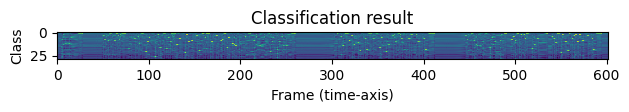

In [ ]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [ ]:
#generate transcript

class GreedyCTCDecoder(torch.nn.Module):
  def __init__(self, labels, blank = 0):
    super().__init__()
    self.labels = labels
    self.blank = blank
  def forward(self, emission: torch.Tensor):
    indices = torch.argmax(emission, dim=-1)
    indices = torch.unique_consecutive(indices, dim=-1)
    indices = [i for i in indices if i!= self.blank]
    return "".join([self.labels[i] for i in indices])


In [ ]:
decoder = GreedyCTCDecoder(labels = bundle.get_labels())
transcript = decoder(emission[0])
transcript = transcript.replace("|", " ").lower()
print(transcript)

hello this is the final project for university of british columbia sama programm i am studying in computer engineering this summer course has been fun and very interesting 


In [ ]:
def transcript(sig):
  sig = sig.to(device)
  if sr != bundle.sample_rate:
    waveform = torchaudio.functional.resample(sig, sr, bundle.sample_rate)
  with torch.inference_mode():
    features, _ = model_asr.extract_features(sig)
  with torch.inference_mode():
    emission, _ = model_asr(waveform)
  decoder = GreedyCTCDecoder(labels = bundle.get_labels())
  transcript = decoder(emission[0])
  transcript = transcript.replace("|", " ").lower()
  print(transcript)



In [ ]:
for sig in sigs:
  transcript(sig)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


hello this is the final project for university of british columbia samue puc
am studying in computerntini
i summer course has been fun and very interesting 


In [ ]:
from transformers import pipeline
import torch

MODEL_NAME = "biodatlab/whisper-th-medium-combined"
lang = "th"

device = 0 if torch.cuda.is_available() else "cpu"

pipe = pipeline(
    task="automatic-speech-recognition",
    model=MODEL_NAME,
    chunk_length_s=30,
    device=device,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

In [ ]:
transcriptions = pipe(
    "audio.mp3",
    batch_size=16,
    return_timestamps=False,
    generate_kwargs={"language": "<|th|>", "task": "transcribe"}
)["text"]
print(transcriptions)

สวัสดีครับ นี่คือตัวอย่างงานสุดท้ายของการเรียนฤดูร้อนในปี 2024 ผมได้มาเรียนวิศวกรรมคอมพิวเตอร์เป็นประสบการณ์ที่สนุกและได้ความรู้ใหม่ใหม่มากมาย


In [ ]:
#translate thai to english

pipe2 = pipeline("translation", model="Helsinki-NLP/opus-mt-th-en")

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/810k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [ ]:
# Install PySpark and Spark NLP
! pip install -q pyspark==3.3.0 spark-nlp==4.2.8

# Install Spark NLP Display lib
! pip install --upgrade -q spark-nlp-display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.8/453.8 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.6 MB/s eta 0:00:00


In [ ]:
tokenizer2 = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-th-en")
model2 = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-th-en")

print(transcriptions)

batch = tokenizer2([transcriptions], return_tensors="pt")

print(batch)

generated_ids = model2.generate(**batch)
eng_text = tokenizer2.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(eng_text)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


สวัสดีครับ นี่คือตัวอย่างงานสุดท้ายของการเรียนฤดูร้อนในปี 2024 ผมได้มาเรียนวิศวกรรมคอมพิวเตอร์เป็นประสบการณ์ที่สนุกและได้ความรู้ใหม่ใหม่มากมาย
{'input_ids': tensor([[ 6511,   880,  3204,   859, 15461, 19111, 13605,  7419,   732, 13322,
          5571, 32570, 26655,  4893,   166,  8497,    73,  3574,   135,   103,
          7362,   614,   614,  2122,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]])}
Hello, this is the last example of summer school in 2024.


In [ ]:
def auto_transcript(input_file, output_file):
    # input_file is a str contains the path of your input video file.
    # output_file is a str contains the path of the .txt file where you save your transcript.